# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model, all steps are present except the iterative estimation of bumps (only one model is estimated in this notebook) and the LOO-CV procedure. Depending on how things go in your analysis we will add these steps later on.

# Tasks left as exercises :
- Changing sampling frequency can be achieved in cell 3, for now we resample at 100Hz as in the original papers
- bootrstrapping can be achieved usind the resample method : https://xarray.pydata.org/en/stable/generated/xarray.DataArray.resample.html
- PCA is applied from cell 7 to 12, changes should occur there


In [18]:
#Loading required libraries, you should have all of these in the .yml 

import mne
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
from mne.decoding import UnsupervisedSpatialFilter
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The following cells allow you to restrict the analysis to a subset of the participants. THis will ease the computational load on your machine but will be removed for the final analysis

In [19]:
path = '../../supervisions/2022/Bachelor_KI/preprocessed_data/'
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
print(subj_names)
subset = subj_names #alternatively for testing purposes subset = ["S1","S2","S3"]

['S6', 'S18', 'S20', 'S1', 'S16', 'S14', 'S7', 'S15', 'S2', 'S3', 'S4', 'S5', 'S17', 'S10', 'S8', 'S12', 'S9', 'S11', 'S13']


# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [20]:
tmin, tmax = -0.2, 2.2 #window of the trials we are interested in (in seconds)
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213, #conditions in the experiment
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events
epoch_data = [] 
offset_after_resp = 100 #how many milliseconds after response should be stored

if 'epoch_data_condition-wise.nc' not in os.listdir():#avoids to loop again if notebook is restarted
    for participant in subset:
        data = mne.io.read_raw_fif(path+'/preprocessed_%s.fif'%participant, preload=False, verbose=False)
        data.load_data()
        data.filter(.5, 30, fir_design='firwin', verbose=False)#Filtering out frequency outside range .5 and 30Hz, as study by Anderson et al. (Berberyan used 40 Hz)
        # Loading events (in our case one event = one trial)
        events = mne.find_events(data, verbose=False)
        #### @Bruno Here you can use the downsampling feature of MNE, e.g.:
        #data, events = data.resample(100, events=events)#100 Hz is the standard used for previous applications of HsMM
        events[:,2] = events[:,2]-events[:,1]#correction on event value
        events_wresp = events

        #Only pick electrodes placed on the scalp:
        picks = mne.pick_types(data.info, eeg=True, stim=False, eog=False, misc=False,
                           exclude='bads') 
        offset_after_resp_samples = int(offset_after_resp/(1000/data.info['sfreq']))

        metadata, events, event_id = mne.epochs.make_metadata(
            events=events, event_id= event_id,
            tmin=tmin, tmax=tmax, sfreq=data.info['sfreq'])

        epochs = mne.Epochs(data, events, event_id, tmin, tmax, proj=False,
                        picks=picks, baseline=(None, 0), preload=True,
                        verbose=False,detrend=1,on_missing = 'warn',
                        metadata=metadata,reject_by_annotation=True)
        data_epoch = epochs.get_data()
        
        valid_epochs_idx = [x for x in np.arange(len(epochs.drop_log)) if epochs.drop_log[x] == ()]

        rts=[]#reaction times
        i,j = 0,0
        while i < len(events_wresp):
            if events_wresp[i,2] in event_id.values() :
                if j in valid_epochs_idx:
                    if events_wresp[i+1,2] in resp_id.values() and events_wresp[i-1,2] == 2:#2 for high force condition 
                        rts.append(events_wresp[i+1,0] - events_wresp[i,0] )
                    if events_wresp[i+1,2] in resp_id.values() and events_wresp[i-1,2] ==1:#1 for low force condition 
                        rts.append(0)
                    elif events_wresp[i+1,2] not in resp_id.values(): #trials without resp
                        rts.append(0)
                j += 1
            i += 1
        rts = np.array(rts)
        rts[rts > data.info['sfreq']*2] = 0 #removes RT above 2 sec
        rts[rts < data.info['sfreq']*.3] = 0 #removes RT below 300 ms, important as determines max bumps
        
        cropped_data_epoch = np.empty([len(rts), len(epochs.ch_names), max(rts)+offset_after_resp_samples])
        cropped_data_epoch[:] = np.nan
        i, j = 0, 0
        for i in np.arange(len(data_epoch)):
            if rts[i] != 0:
            #Crops the epochs to time 0 (stim onset) up to RT
                cropped_data_epoch[j,:,:rts[i]+offset_after_resp_samples] = (data_epoch[i,:,epochs.time_as_index(0)[0]:
                                    epochs.time_as_index(0)[0]+int(rts[i])+offset_after_resp_samples])
                j += 1

        # recover actual data points in a 3D matrix with dimensions trials X electrodes X sample
        epoch_data.append(xr.Dataset(
            {
                "data": (["epochs", "electrodes", "samples"],cropped_data_epoch),
                "event": (["epochs"], epochs.metadata["event_name"]),
            },
            coords={
                "epochs" : np.arange(len(cropped_data_epoch)),
                "electrodes":  epochs.ch_names,
                # TODO When time "electrodes": (['name','x','y','z'], epochs.ch_names,
                "samples": np.arange(max(rts)+offset_after_resp_samples)#+1)
            },
            attrs={'sfreq':epochs.info['sfreq']}
            )
        )

    epoch_data = xr.concat(epoch_data, dim="participant")
    epoch_data.coords['participant'] =  subset
    epoch_data.to_netcdf('epoch_data_condition-wise.nc')
epoch_data = xr.open_dataset('epoch_data_condition-wise.nc')

In [21]:
epoch_data

<xarray.Dataset>
Dimensions:      (participant: 1, epochs: 2240, electrodes: 64, samples: 1935)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 ... 2234 2235 2236 2237 2238 2239
  * electrodes   (electrodes) object 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * samples      (samples) int64 0 1 2 3 4 5 6 ... 1929 1930 1931 1932 1933 1934
  * participant  (participant) object 'S1'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 ...
    event        (participant, epochs) object ...
Attributes:
    sfreq:    1024.0

# Applying HsMM for the speed condition

In [22]:
speed, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('speed'),drop=True),\
                           'participant',stack=True)

In [23]:
speed_init = hsmm.hsmm(speed.data.T, starts, ends, sf=epoch_data.sfreq)

In [24]:
max_estimates = speed_init.fit_single(speed_init.max_bumps())

Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:203: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:209: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 8 bumps model


In [25]:
bump_loo_results = [max_estimates]

i = 1
for n_bumps in np.arange(speed_init.max_bumps()-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
    possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(speed_init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
                #repeat(np.tile([1,50], (n_bumps,1))),
                #repeat(np.tile([2,12], (n_bumps,1)))))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
    i+=1
bests = xr.concat(bump_loo_results, dim="n_bumps")
bests = bests.assign_coords({"n_bumps": np.arange(speed_init.max_bumps(),0,-1)})
bests = bests.squeeze('iteration')
bests

Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters

<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 1935, trial: 565)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.527e+04 -1.036e+04 ... -3.324e+03
    parameters   (n_bumps, stage, params) float64 2.0 107.5 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 0.7712 0.2684 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

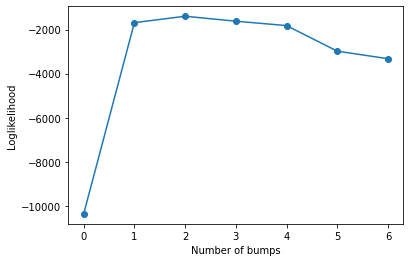

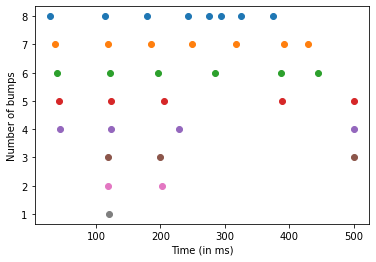

In [26]:
plt.plot(np.arange(speed_init.max_bumps()-1), bests.likelihoods[1:],'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(speed_init.max_bumps(),0,-1):
    times = speed_init.mean_bump_times(bests.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(speed_init.max_bumps())+1)
plt.ylabel('Number of bumps');

# Applying HsMM for the accuracy condition

In [27]:
accuracy, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('accuracy'),drop=True),\
                           'participant',stack=True)

In [28]:
accuracy_init = hsmm.hsmm(accuracy.data.T, starts, ends, sf=epoch_data.sfreq)

In [29]:
max_estimates = accuracy_init.fit_single(accuracy_init.max_bumps())

Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:203: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:209: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 8 bumps model


In [30]:
bump_loo_results = [max_estimates]

i = 1
for n_bumps in np.arange(accuracy_init.max_bumps()-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
    possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(accuracy_init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
                #repeat(np.tile([1,50], (n_bumps,1))),
                #repeat(np.tile([2,12], (n_bumps,1)))))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
    i+=1
bests = xr.concat(bump_loo_results, dim="n_bumps")
bests = bests.assign_coords({"n_bumps": np.arange(accuracy_init.max_bumps(),0,-1)})
bests = bests.squeeze('iteration')
bests

Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 7 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters

<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 1823, trial: 405)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.352e+04 -8.644e+03 ... -2.359e+03
    parameters   (n_bumps, stage, params) float64 2.0 101.3 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 0.7325 0.3992 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

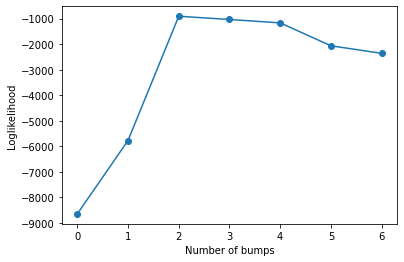

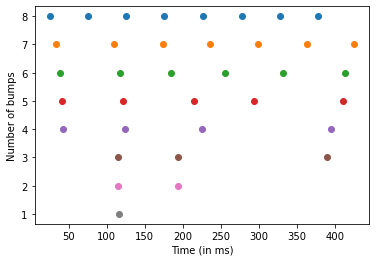

In [31]:
plt.plot(np.arange(accuracy_init.max_bumps()-1), bests.likelihoods[1:],'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(accuracy_init.max_bumps(),0,-1):
    times = accuracy_init.mean_bump_times(bests.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(accuracy_init.max_bumps())+1)
plt.ylabel('Number of bumps');

In [32]:
bump3_estimates_speed = speed_init.fit_single(3)

Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:203: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:209: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 3 bumps model


In [33]:
bump3_estimates_accuracy = accuracy_init.fit_single(3)

Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model


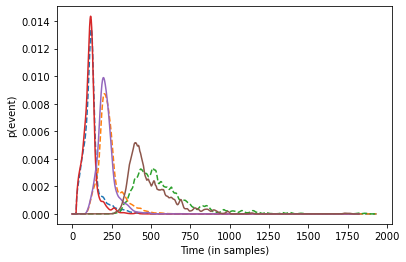

In [34]:
plt.plot(bump3_estimates_speed.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2]),'--')
plt.plot(bump3_estimates_accuracy.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2]))
plt.ylabel('p(event)')
plt.xlabel('Time (in samples)');